# Loading the MNIST data, which comes pre-loaded with TensorFlow

In [1]:
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", reshape=False)
X_train, y_train           = mnist.train.images, mnist.train.labels
X_validation, y_validation = mnist.validation.images, mnist.validation.labels
X_test, y_test             = mnist.test.images, mnist.test.labels

assert(len(X_train) == len(y_train))
assert(len(X_validation) == len(y_validation))
assert(len(X_test) == len(y_test))

print("\n Image Shape: {} \n".format(X_train[0].shape))
print("Training Set:   {} samples".format(len(X_train)))
print("Validation Set: {} samples".format(len(X_validation)))
print("Test Set:       {} samples".format(len(X_test)))

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz

 Image Shape: (28, 28, 1) 

Training Set:   55000 samples
Validation Set: 5000 samples
Test Set:       10000 samples


In [2]:
## MNIST dataset has as 28x28x1 shape.
## Architecture we are suing for this example only accepts 32x32x? images (? = color channels)
# Loaded data set size is 28x28 we would need to be reshaped to 1x32x32x1
import numpy as np
img_size = 32

if X_train[0].shape[1] is not img_size:
    X_train      = np.pad(X_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_validation = np.pad(X_validation, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    X_test       = np.pad(X_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(X_train[0].shape))

Updated Image Shape: (32, 32, 1)


# How does this data set looks like?

4


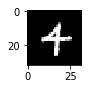

In [3]:
import random
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

# Architecture

In [4]:
# For this example I am using LeNet architecture 
# http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf

import tensorflow as tf
from tensorflow.contrib.layers import flatten

tf.reset_default_graph()

# Using tf.truncated_normal to initilize weights and biases varibles
# with random normal distribution 
mu = 0
sigma = 0.1

conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
conv1_b = tf.Variable(tf.zeros(6))

conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
conv2_b = tf.Variable(tf.zeros(16))

fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
fc1_b = tf.Variable(tf.zeros(120))

fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
fc2_b  = tf.Variable(tf.zeros(84))

fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 10), mean = mu, stddev = sigma))
fc3_b  = tf.Variable(tf.zeros(10))

def LeNet(x):     
    
    print(x.shape)
    #Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)
    #Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    #Layer 2: Convolutional. Output = 10x10x16.
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.relu(conv2)
    #Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    #Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.relu(fc1)

    #Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    fc2    = tf.nn.relu(fc2)

    #Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

#Placeholder variables
x = tf.placeholder(tf.float32, (None, img_size, img_size, 1))
y = tf.placeholder(tf.int32, (None))

save_path = 'model/model.ckpt'

In [5]:
EPOCHS = 20
BATCH_SIZE = 128

rate = 0.001
one_hot_y = tf.one_hot(y, 10)

# Get logits
logits = LeNet(x)
# Computes softmax cross entropy between logits and labels
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
#Calculate loss
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Add an op to initialize the variables.
init_op = tf.global_variables_initializer()
saver = tf.train.Saver()

(?, 32, 32, 1)


In [6]:
#set validation system 
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

# Start tensorflow training session

In [7]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9847918478355800342, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3242563993
 locality {
   bus_id: 1
 }
 incarnation: 15552436628156133014
 physical_device_desc: "device: 0, name: GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"]

In [8]:
import time
beginTime = time.time()
lastTime = beginTime
with tf.device('/device:GPU:0'):
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(init_op)
        dataLen = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            for offset in range(0, dataLen, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(X_validation, y_validation)

        save_path = saver.save(sess, 'model/model.ckpt')
        print("Model saved")
        
endTime = time.time()
print ("Total time {:5.2f}s".format(endTime - beginTime))

Training...

Model saved
Total time 60.76s


In [9]:
import time
beginTime = time.time()
lastTime = beginTime
with tf.device('/device:CPU:0'):
    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(init_op)
        dataLen = len(X_train)

        print("Training...")
        print()
        for i in range(EPOCHS):
            for offset in range(0, dataLen, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            validation_accuracy = evaluate(X_validation, y_validation)

        save_path = saver.save(sess, 'model/model.ckpt')
        print("Model saved")
endTime = time.time()
print ("Total time {:5.2f}s".format(endTime - beginTime))

Training...

Model saved
Total time 56.04s
